# Machine Learning Foundation

## Course 3, Part a: Logistic Regression LAB

## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

For each record in the dataset it is provided: 

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration. 
- Triaxial Angular velocity from the gyroscope. 
- A 561-feature vector with time and frequency domain variables. 
- Its activity label. 

More information about the features is available on the website above.

In [1]:
import os, seaborn as sns, pandas as pd, numpy as np
sns.set_palette("viridis")

## Question 1

Import the data and do the following:

* Examine the data types--there are many columns, so it might be wise to use value counts
* Determine if the floating point values need to be scaled
* Determine the breakdown of each activity
* Encode the activity label as an integer

In [2]:
data = pd.read_csv('data/Human_Activity_Recognition_Using_Smartphones_Data.csv', sep=',')

The data columns are all floats except for the activity label.

In [3]:
data.dtypes.value_counts()

float64    561
object       1
dtype: int64

In [4]:
data.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

The data are all scaled from -1 (minimum) to 1.0 (maximum).

In [5]:
data.iloc[:, :-1].min().value_counts()

-1.0    561
dtype: int64

In [6]:
data.iloc[:, :-1].max().value_counts()

1.0    561
dtype: int64

Examine the breakdown of activities--they are relatively balanced.

In [7]:
data.Activity.value_counts()

LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: Activity, dtype: int64

Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either `LabelEncoder` needs to be used to convert the activity labels to integers, or if `DictVectorizer` is used, the resulting matrix must be converted to a non-sparse array.  
Use `LabelEncoder` to fit_transform the "Activity" column, and look at 5 random values.

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(5)

5255    5
6625    2
3785    4
8780    0
6872    0
Name: Activity, dtype: int32

## Question 2

* Calculate the correlations between the dependent variables.
* Create a histogram of the correlation values
* Identify those that are most correlated (either positively or negatively).

In [9]:
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values
               .stack()
               .to_frame()
               .reset_index()
               .rename(columns={'level_0':'feature1',
                                'level_1':'feature2',
                                0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

A histogram of the absolute value correlations.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

[Text(0.5, 0, 'Absolute Correlation'), Text(0, 0.5, 'Frequency')]

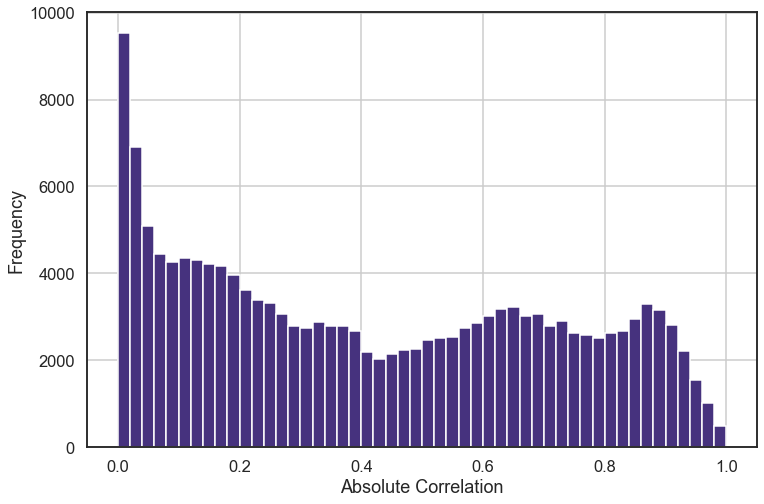

In [11]:
sns.set_context('talk')
sns.set_style('white')

ax = corr_values.abs_correlation.hist(bins=50, figsize=(12, 8))
ax.set(xlabel='Absolute Correlation', ylabel='Frequency')

In [12]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
93902,tBodyAccMag-sma(),tGravityAccMag-sma(),1.000000,1.000000
101139,tBodyAccJerkMag-mean(),tBodyAccJerkMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
94257,tBodyAccMag-energy(),tGravityAccMag-energy(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


## Question 3

* Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
* Regardless of methods used to split the data, compare the ratio of classes in both the train and test splits.


In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']

In [14]:
y_train.value_counts(normalize=True)

0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: Activity, dtype: float64

In [15]:
y_test.value_counts(normalize=True)

0    0.188673
2    0.185113
1    0.172492
3    0.167314
5    0.149838
4    0.136570
Name: Activity, dtype: float64

## Question 4

* Fit a logistic regression model without any regularization using all of the features. Be sure to read the documentation about fitting a multi-class model so you understand the coefficient output. Store the model.
* Using cross validation to determine the hyperparameters, fit models using L1, and L2 regularization. Store each of these models as well. Note the limitations on multi-class models, solvers, and regularizations. The regularized models, in particular the L1 model, will probably take a while to fit.

In [16]:
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

In [17]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=3, cv=3, penalty='l1', solver='liblinear').fit(X_train, y_train)

In [18]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=3, cv=3, penalty='l2', solver='liblinear').fit(X_train, y_train)

## Question 5

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [19]:
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)

lr                                                     l1  \
            0         1         2         3         4         5    0   
93   0.038343 -0.039503  0.347060 -0.515394  0.740662 -0.649554  0.0   
237  0.106739  0.215386 -0.092231  0.296661 -0.079701 -0.214612  0.0   
172  0.008258  0.089767 -0.163936 -0.165170  0.310972 -0.235715  0.0   
199 -0.073598  0.467436  0.195564  0.744608  0.579544 -1.152761  0.0   
264 -0.046754  0.653927 -0.583979  0.036379 -0.269136  0.354203  0.0   
401 -0.007959  0.221205  0.127256  0.499887  0.162896 -0.169742  0.0   
94   0.030394  0.062221  0.302152 -0.762586  0.318511  0.115725  0.0   
104  0.024785  1.766760 -1.807891  1.576000 -0.770465  0.763951  0.0   
261 -0.029785  0.035091 -0.119532 -0.855415  0.099608  0.456417  0.0   
118  0.091168  0.926293 -1.012946  0.608356 -0.105162 -0.756243  0.0   

                                                             l2            \
            1         2         3         4         5         0         1   
93   0.000000  0.000000 -0.502477  1.738554 -1.287830  0.073117 -0.039503   
237  0.000000  0.000000  0.085942 -0.374714 -0.509513  0.195553  0.215385   
172  0.000000  0.000000 -0.642010  0.499348 -0.568222  0.016312  0.089767   
199  0.464030  0.000000  1.652415  2.526192 -3.386080 -0.118647  0.467436   
264  0.343272 -0.167655  1.725731 -1.010230 -0.089584 -0.092304  0.653926   
401  0.103476  0.000000  0.661162  0.039192 -0.105342 -0.034778  0.221205   
94   0.000000  0.000000 -1.421018  0.656924  0.287891  0.054257  0.062221   
104  2.045467 -4.296298  2.919886 -1.869949  2.916678  0.139715  1.766760   
261  0.000000  0.000000 -2.463843  0.032412  0.853543 -0.045458  0.035091   
118  0.898652 -1.192630  1.115077  0.026251 -2.175600  0.206777  0.926293   

                                             
            2         3         4         5  
93   0.347060 -0.935682  3.207990 -3.780945  
237 -0.092231  0.460413 -0.447423 -0.969793  
172 -0.163936 -0.939640  1.350804 -1.057087  
199  0.195564  1.950563  2.800793 -4.969908  
264 -0.583979  0.250707 -1.191366  1.529478  
401  0.127256  1.806301  0.719366 -1.059316  
94   0.302152 -2.733298  1.683008  0.876103  
104 -1.807891  4.666339 -2.681143  3.407408  
261 -0.119532 -2.589576  0.549914  1.589459  
118 -1.012946  1.164687 -0.629954 -2.422369

Prepare six separate plots for each of the multi-class coefficients.

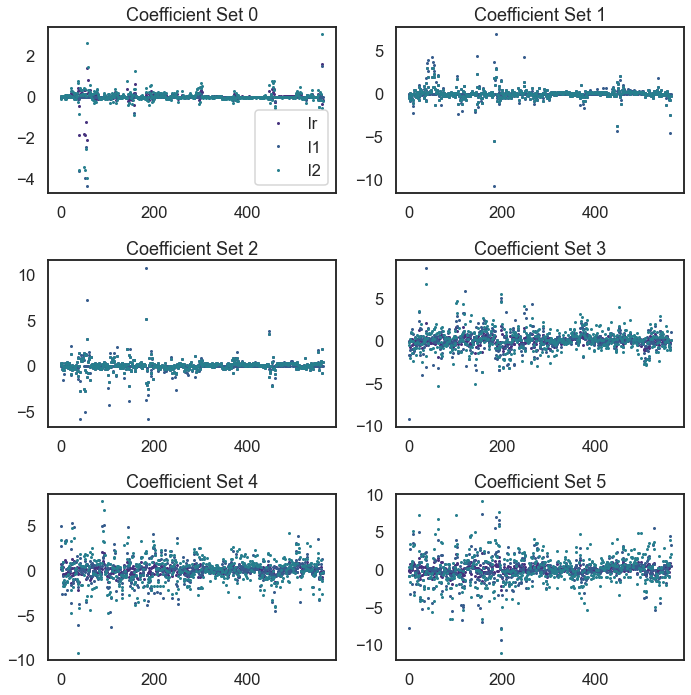

In [20]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)

for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data = coefficients.xs(loc, level=1, axis=1)
    data.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()

## Question 6

* Predict and store the class for each model.
* Store the probability for the predicted class for each model. 

In [21]:
# Predict the class and the probability for each
y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()

,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


In [22]:
y_prob.head()

,lr,l1,l2
0,0.998939,0.997982,0.999264
1,0.988165,0.999689,0.999994
2,0.987592,0.993666,0.995667
3,0.981381,0.993302,0.981612
4,0.998277,0.998445,0.998284


## Question 7

For each model, calculate the following error metrics: 

* Accuracy
* Precision
* Recall
* F-score
* Confusion Matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [23]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)

In [24]:
metrics

,lr,l1,l2
precision,0.984144,0.984469,0.985120
recall,0.984142,0.984466,0.985113
fscore,0.984143,0.984465,0.985114
accuracy,0.984142,0.984466,0.985113
auc,0.990384,0.990544,0.990945


## Question 8

Display or plot the confusion matrix for each model.

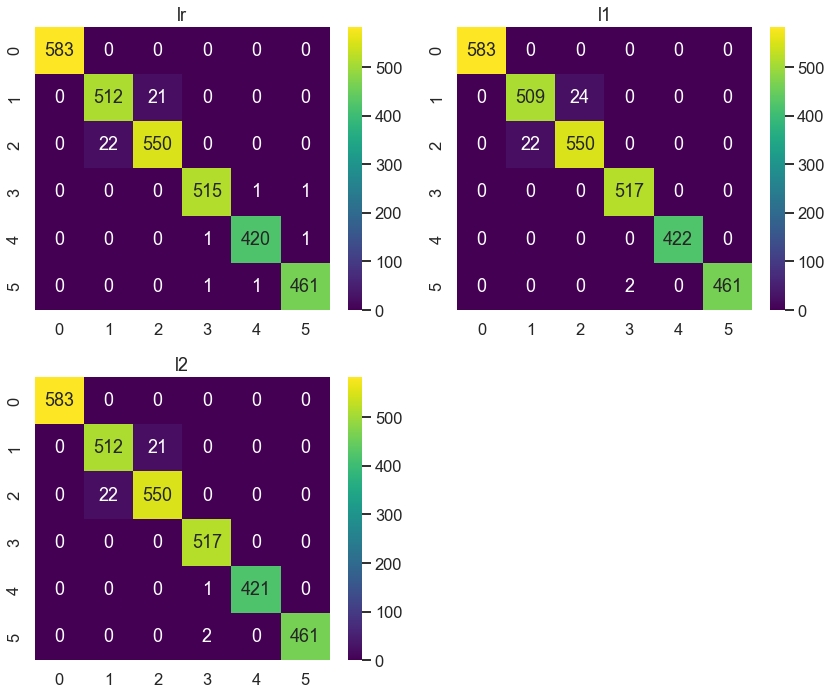

In [25]:
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d', cmap='viridis')
    ax.set(title=lab)
    
plt.tight_layout()

---
### Machine Learning Foundation (C) 2020 IBM Corporation